In [9]:
import numpy as np

import pandas as pd

import seaborn as sns

from pandas import Series,DataFrame
%matplotlib inline

In [10]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [11]:
test.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [12]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [13]:
train.describe()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id20724,Overall I find the Embassy Suites North very n...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
User_ID         38932 non-null object
Description     38932 non-null object
Browser_Used    38932 non-null object
Device_Used     38932 non-null object
Is_Response     38932 non-null object
dtypes: object(5)
memory usage: 1.5+ MB


In [15]:
train['Is_Response'].describe()

count     38932
unique        2
top       happy
freq      26521
Name: Is_Response, dtype: object

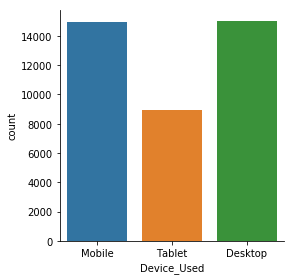

In [16]:
import seaborn as sns
sns.factorplot(x='Device_Used', data = train, kind = 'count')

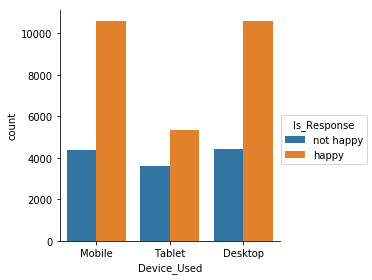

In [17]:
sns.factorplot(x='Device_Used', data = train, kind = 'count', hue = 'Is_Response')

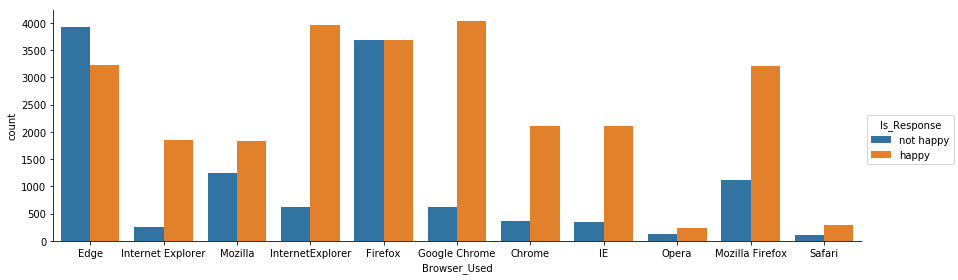

In [18]:
sns.factorplot(x='Browser_Used', data = train, kind = 'count', hue = 'Is_Response', size = 4, aspect=3)

# Couldn't find significant feature 

In [19]:
from nltk.corpus import stopwords

In [20]:
def text_process(mess):
    """
    Takes in a string of text and:
    1. Removes all punctuation
    2. Removes all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [21]:
train.head()
import string

In [22]:
train['Description'].head(5).apply(text_process)

0    [room, kind, clean, strong, smell, dogs, Gener...
1    [stayed, Crown, Plaza, April, April, staff, fr...
2    [booked, hotel, Hotwire, lowest, price, could,...
3    [Stayed, husband, sons, way, Alaska, Cruise, l...
4    [girlfriends, stayed, celebrate, th, birthdays...
Name: Description, dtype: object

In [23]:
train['Description'].head()

0    The room was kind of clean but had a VERY stro...
1    I stayed at the Crown Plaza April -- - April -...
2    I booked this hotel through Hotwire at the low...
3    Stayed here with husband and sons on the way t...
4    My girlfriends and I stayed here to celebrate ...
Name: Description, dtype: object

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(train['Description'])

# Print total number of vocab words
print (len(bow_transformer.vocabulary_))

80055


In [26]:
des_bow = bow_transformer.transform(train['Description'])
print ('Shape of Sparse Matrix: ', des_bow.shape)
print ('Amount of Non-Zero occurences: ', des_bow.nnz)
print ('sparsity: %.3f%%' % (100.0 * des_bow.nnz / (des_bow.shape[0] * des_bow.shape[1])))

Shape of Sparse Matrix:  (38932, 80055)
Amount of Non-Zero occurences:  2619062
sparsity: 0.084%


In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_trans = TfidfTransformer().fit(des_bow)
des_tfidf = tfidf_trans.transform(des_bow)
print (des_tfidf.shape)

(38932, 80055)


In [28]:
from sklearn.naive_bayes import MultinomialNB


In [30]:
happy_detect_model = MultinomialNB().fit(des_tfidf, train['Is_Response'])

In [36]:
all_pred = happy_detect_model.predict(des_tfidf)
print (all_pred)

['happy' 'happy' 'happy' ..., 'not happy' 'not happy' 'happy']


In [39]:
# predicted off train data so wrong....


In [40]:
from sklearn.metrics import classification_report

print (classification_report(train['Is_Response'], all_pred))

             precision    recall  f1-score   support

      happy       0.79      1.00      0.88     26521
  not happy       0.98      0.43      0.59     12411

avg / total       0.85      0.81      0.79     38932



In [41]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])


In [43]:
from sklearn.cross_validation import train_test_split

des_train, des_test, res_train, res_test = \
train_test_split(train['Description'], train['Is_Response'], test_size=0.2)

print (len(des_train), len(des_test), len(des_train) + len(des_test))


31145 7787 38932


/home/daniel/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
pipeline.fit(des_train,res_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x7f8ce2048620>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [45]:
predictions = pipeline.predict(test['Description'])




In [46]:
predictions

array(['happy', 'happy', 'happy', ..., 'happy', 'happy', 'happy'],
      dtype='<U9')

In [47]:
test['res'] = DataFrame(predictions)

In [48]:
test.head()

,User_ID,Description,Browser_Used,Device_Used,res
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile,happy
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop,happy
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet,happy
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile,happy
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile,happy


In [50]:
submission = test['User_ID']

In [56]:
submission['Is_Response'] = pd.DataFrame(predictions)

In [58]:
predictions



array(['happy', 'happy', 'happy', ..., 'happy', 'happy', 'happy'],
      dtype='<U9')

In [64]:
sub1 = DataFrame(predictions)
sub1.columns = ['Is_Response']

In [65]:
sub1

,Is_Response
0,happy
1,happy
2,happy
3,happy
4,happy
5,happy
6,happy
7,not happy
8,happy
9,happy


In [73]:
Sub2 = DataFrame(test['User_ID'])
Sub2.columns = ['User_ID']

In [74]:
Sub2

,User_ID
0,id80132
1,id80133
2,id80134
3,id80135
4,id80136
5,id80137
6,id80138
7,id80139
8,id80140
9,id80141


In [81]:
finalsub = pd.concat([Sub2,sub1], axis = 1)

In [82]:
finalsub

,User_ID,Is_Response
0,id80132,happy
1,id80133,happy
2,id80134,happy
3,id80135,happy
4,id80136,happy
5,id80137,happy
6,id80138,happy
7,id80139,not happy
8,id80140,happy
9,id80141,happy


In [84]:
finalsub.to_csv('submisssion.csv', index=False)